# Beam parameter scan through a foil
K. Sjobak, October 23rd 2018

Scan beam parameters at focal point, computing the twiss parameters modification (incl. emittance growth) by a scattering foil.

Note that it is based on a stand-alone (not Jupyter) script which used an early version of the Python wrapper that did not contain miniScatterScanner.
I chose to keep it like this, as it nicely illustrates how miniScatterDriver works, which is useful to know even if you are directly interacting with the Scanner only.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PLT_NOTEBOOK = False
if PLT_NOTEBOOK:
    %matplotlib notebook
else:
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.rcParams['figure.dpi'] = 100

    #colorCycle = plt.rcParams['axes.prop_cycle']
    #plt.rcParams['figure.max_open_warning'] = 100
    
    #import IPython

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)

import miniScatterDriver
#import miniScatterScanner

import os
runFolder = os.getcwd()
tmpFolder = os.path.join(runFolder,"tmp")
if not os.path.exists(tmpFolder):
    print("Making folder '{}'".format(tmpFolder))
    os.mkdir(tmpFolder)

Welcome to JupyROOT 6.14/02


# General simulation setup

In [5]:
NUMEVENTS = 10000000
NUMBETA = 20

In [6]:
def TwissDrift(beta_in:float, gamma_in:float, alpha_in:float, L:float) -> tuple:
    beta_out  = beta_in + L**2 * gamma_in - 2*L*alpha_in
    gamma_out =                  gamma_in
    alpha_out =         -    L * gamma_in     + alpha_in
    return (beta_out, gamma_out, alpha_out)

def getGamma(beta_in:float, alpha_in:float):
    return (1.0 + alpha_in**2)/beta_in

def runSimulations(eps_0x=1.0, eps_0y=1.0, alpha_0=-5.0, THICK=3e-3, MAT="G4_MYLAR", N=1000000, N_beta=10):
    """
    Run a simulation of the effect on the twiss parameters some distance after a scattering foil,
    given the emittance [um] and alpha_0 at this point had the foil not been there,
    as well as the thickness of the foil [mm] and the foil material.
    """
    
    #This is what we want to scan
    beta_0   = np.logspace(np.log10(0.0001),np.log10(1.50),N_beta) #[m]

    #System parameters
    L = 0.202 #[m] Capillary-to-foil distance
    Lcap = 0.015 #[m] Capillary length
    L = L + Lcap/2.0 #We actually care about the middle of the capillary

    matstr = MAT
    if MAT == "G4_MYLAR":
        matstr = "Mylar"
    elif MAT == "G4_KAPTON":
        matstr = "Kapton"
    plottitle = "{0:.1f} $\\mu$m {1}, $\\alpha_0={2:.1f}$, $\\varepsilon_0 = {3:.1f}:{4:.1f}$ [$\\mu$m]".\
                                                  format(THICK*1000, matstr, alpha_0, eps_0x,eps_0y)

    #Simulation parameters
    baseSimSetup = {}
    baseSimSetup["N"]       = N
    baseSimSetup["DIST"]    = L*1000 #[mm]
    baseSimSetup["ENERGY"]  = 210.0
    baseSimSetup["ZOFFSET"] = -THICK
    baseSimSetup["ZOFFSET_BACKTRACK"] = True
    # Use single-scattering electromagnetics for more accurate scattering angles in thin foils
    baseSimSetup["PHYS"] = "QGSP_BERT__SS"
    baseSimSetup["QUICKMODE"] = True
    baseSimSetup["MAT"] = MAT
    baseSimSetup["THICK"] = THICK
     # Include all charged particles with E > 0.95*E_0 (default) for the "cutoff" twiss parameters
    baseSimSetup["CUTOFF_RADIUS"] = 200.0 #[mm]
    
    baseSimSetup["OUTFOLDER"] = tmpFolder
    # Simulations are running sequentially, so they can all use the same filename.
    # The .root postfix gets added automatically by MiniScatter.
    baseSimSetup["OUTNAME"]   = "output"

    #Assume electron beam
    gamma_rel = baseSimSetup["ENERGY"]/0.511
    beta_rel  = np.sqrt(gamma_rel**2 - 1.0) / gamma_rel;

    print ("plottile  = '"+plottitle+"'")
    print ("gamma_rel =", gamma_rel)
    print ("beta_rel  =", beta_rel)
    
    #Make output folder
    import os
    dirpath="plots/beamParamScan_alpha0={0:.1f}_eps0={1:.1f}:{2:.1f}_THICK={3}_MAT={4}_Npoints={5}".\
        format(alpha_0,eps_0x,eps_0y,THICK,MAT,len(beta_0))
    
    if not os.path.exists("plots"):
        print()
        print("Making folder 'plots'")
        os.mkdir("plots")
    
    try:
        print()
        print("Making folder '"+dirpath+"'")
        os.mkdir(dirpath)
    except FileExistsError:
        print("Aready there! nuking it.")
        import shutil
        shutil.rmtree(dirpath)
        os.mkdir(dirpath)
    print()

    #Computed parameters
    eps_x   = np.empty_like(beta_0)
    beta_x  = np.empty_like(beta_0)
    alpha_x = np.empty_like(beta_0)
    sigma_x = np.empty_like(beta_0)

    eps_y   = np.empty_like(beta_0)
    beta_y  = np.empty_like(beta_0)
    alpha_y = np.empty_like(beta_0)
    sigma_y = np.empty_like(beta_0)

    sigma_0x   = np.empty_like(beta_0)
    sigma_0y   = np.empty_like(beta_0)
    beta_foil  = np.empty_like(beta_0)
    alpha_foil = np.empty_like(beta_0)

    #Plot the beam development as function of s
    
    fig1 = plt.figure()
    fig2 = plt.figure()
    
    # These extra-wide figures do not play nicely with Jupyter
    if not PLT_NOTEBOOK:
        default_size = plt.rcParams.get('figure.figsize')
        double_width = np.asarray(default_size)
        double_width[0] *= 2
        plt.figure(fig1.number,figsize=double_width)
        plt.subplots_adjust(left=0.06,right=0.98)
        plt.figure(fig2.number,figsize=double_width)
        plt.subplots_adjust(left=0.06,right=0.98)
    


    sPos = np.linspace(-1.25*L,0.25*L,200)

    for i in range(len(beta_0)):
        gamma_0 = getGamma(beta_0[i],alpha_0)
        (beta_foil[i],gamma_foil,alpha_foil[i]) = TwissDrift(beta_0[i],gamma_0,alpha_0,-L)

        COVAR = (eps_0x,beta_foil[i],alpha_foil[i],eps_0y,beta_foil[i],alpha_foil[i])

        sigma_0x[i] = np.sqrt(eps_0x*beta_0[i]*1e6/(gamma_rel*beta_rel))
        sigma_0y[i] = np.sqrt(eps_0y*beta_0[i]*1e6/(gamma_rel*beta_rel))
        print("Simulation", i+1, "of",len(beta_0))
        print("Simulating for beta_0 =", beta_0[i], "[m]")
        print("Sigma_0               =", sigma_0x[i], "and", sigma_0y[i], "[um]")

        simSetup = baseSimSetup.copy()
        simSetup["COVAR"] = COVAR
        simSetup["SEED"]  = i+1
        
        miniScatterDriver.runScatter(simSetup)
        
        (twiss,numPart,objects) = miniScatterDriver.getData("tmp/output.root")
        #print(twiss)
        
        eps_x[i]   = twiss['tracker_cutoff']['x']['eps']
        beta_x[i]  = twiss['tracker_cutoff']['x']['beta']
        alpha_x[i] = twiss['tracker_cutoff']['x']['alpha']
        sigma_x[i] = np.sqrt(eps_x[i]*beta_x[i]*1e6/(gamma_rel*beta_rel))

        eps_y[i]   = twiss['tracker_cutoff']['y']['eps']
        beta_y[i]  = twiss['tracker_cutoff']['y']['beta']
        alpha_y[i] = twiss['tracker_cutoff']['y']['alpha']
        sigma_y[i] = np.sqrt(eps_y[i]*beta_y[i]*1e6/(gamma_rel*beta_rel))

        plt.figure(fig1.number)
        beta0_s = TwissDrift(beta_0[i],gamma_0,alpha_0,sPos)[0]
        gamma_x = getGamma(beta_x[i],alpha_x[i])
        beta_xs = TwissDrift(beta_x[i],gamma_x,alpha_x[i],sPos)[0]
        l1 = plt.plot(sPos,np.sqrt(eps_0x*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0]
        plt.plot(sPos,np.sqrt(eps_x[i]*beta_xs*1e6/(gamma_rel*beta_rel)),\
                 label='{0:.3g}'.format(beta_0[i]*100), ls="-",color=l1.get_color())

        plt.figure(fig2.number)
        beta0_s = TwissDrift(beta_0[i],gamma_0,alpha_0,sPos)[0]
        gamma_y = getGamma(beta_y[i],alpha_y[i])
        beta_ys = TwissDrift(beta_y[i],gamma_y,alpha_y[i],sPos)[0]
        l1 = plt.plot(sPos,np.sqrt(eps_0y*beta0_s*1e6/(gamma_rel*beta_rel)), ls="--" )[0]
        plt.plot(sPos,np.sqrt(eps_y[i]*beta_ys*1e6/(gamma_rel*beta_rel)),\
                 label='{0:.3g}'.format(beta_0[i]*100), ls="-",color=l1.get_color())

        print("Twiss (X):", twiss['tracker_cutoff']['x']['eps'], \
                            twiss['tracker_cutoff']['x']['beta'], \
                            twiss['tracker_cutoff']['x']['alpha'])
        print("Twiss (Y):", twiss['tracker_cutoff']['y']['eps'], \
                            twiss['tracker_cutoff']['y']['beta'], \
                            twiss['tracker_cutoff']['y']['alpha'])
        print("Sigma (X):",sigma_x[i], "[um]")
        print("Sigma (Y):",sigma_y[i], "[um]")
        print()

    ### Finish plots ###
    print("Plotting..")

    import matplotlib.transforms as mtransforms

    plt.figure(fig1.number)
    plt.title(plottitle)
    plt.axvline(-L, ls='-',color='blue')
    trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
    plt.fill_between([-Lcap/2.0, Lcap/2.0], 0, 1, facecolor='gray', alpha=0.25, transform=trans)
    plt.xlabel('s [m]')
    plt.ylabel('$\\sigma_x$ [$\\mu$m]')
    plt.legend(loc=0,ncol=4,title="$\\beta_0$ [cm]")
    plt.savefig(dirpath + "/" + "sigma-s.png")
    plt.ylim(0,200)
    #plt.savefig(dirpath + "/" + "sigmax-s-ZOOM.png")
    #plt.ylim(0,100)
    #plt.savefig(dirpath + "/" + "sigmax-s-ZOOM2.png")
    
    plt.figure(fig2.number)
    plt.title(plottitle)
    plt.axvline(-L, ls='-',color='blue')
    trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
    plt.fill_between([-Lcap/2.0, Lcap/2.0], 0, 1, facecolor='gray', alpha=0.25, transform=trans)
    plt.xlabel('s [m]')
    plt.ylabel('$\\sigma_y$ [$\\mu$m]')
    plt.legend(loc=0,ncol=4,title="$\\beta_0$ [cm]")
    plt.savefig(dirpath + "/" + "sigmay-s.png")
    plt.ylim(0,200)
    #plt.savefig(dirpath + "/" + "sigmay-s-ZOOM.png")
    #plt.ylim(0,100)
    #plt.savefig(dirpath + "/" + "sigmay-s-ZOOM2.png")

    #Used for a lot of vertical lines
    minEpsIdx_x = np.argmin(eps_x)
    minEpsIdx_y = np.argmin(eps_y)

    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(beta_0*100,eps_x, label="$\\varepsilon_x$")[0]
    l_y = plt.plot(beta_0*100,eps_y, label="$\\varepsilon_y$")[0]
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.ylabel("$\\varepsilon_N$ [$\\mu$m]")
    plt.axhline(eps_0x,ls='--', label="$\\varepsilon_{x,0}$", color=l_x.get_color())
    plt.axhline(eps_0y,ls='--', label="$\\varepsilon_{y,0}$", color=l_y.get_color())
    plt.legend(loc=0)
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    #plt.savefig(dirpath + "/" + "epsN-beta0.png")
    #plt.ylim(0,max(eps_x[-1],eps_y[-1])*1.2)
    #plt.savefig(dirpath + "/" + "epsN-beta0-ZOOM.png")
    plt.yscale('log')

    plt.figure()
    ax1 = plt.gca()
    plt.title(plottitle)
    l_bf = plt.plot(beta_0*100,beta_foil*100)[0]
    plt.ylabel("$\\beta_{foil} [cm]$")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    plt.yscale('log')
    ax2=plt.twinx()
    l_af = ax2.plot(beta_0*100,alpha_foil, ls="--")[0]
    ax2.set_ylabel("$\\alpha_{foil}$")
    plt.subplots_adjust(right=0.82)
    plt.figlegend(labels=("$\\beta$","$\\alpha$"), handles=(l_bf, l_af), loc='upper center',bbox_to_anchor=(0.5, 0.88))
    #plt.savefig(dirpath + "/" + "twissFoil-beta0.png")
    #ax1.set_ylim(0,beta_foil[-1]*100*1.5)
    #ax2.set_ylim(0,alpha_foil[np.argmin(beta_foil)]*1.5)
    #plt.savefig(dirpath + "/" + "twissFoil-beta0-ZOOM.png")
    plt.yscale('log')

    plt.figure()
    plt.title(plottitle)
    l_bx=plt.plot(beta_0*100,beta_x*100)[0]
    l_by=plt.plot(beta_0*100,beta_y*100)[0]
    plt.ylabel("$\\beta_{capillary} [cm]$")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_bx.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_by.get_color(),ls='--')
    ax2=plt.twinx()
    l_ax=ax2.plot(beta_0*100,alpha_x, ls="--")[0]
    l_ay=ax2.plot(beta_0*100,alpha_y, ls="--")[0]
    ax2.set_ylabel("$\\alpha_{capillary}$")
    plt.subplots_adjust(right=0.85)
    plt.figlegend(labels=("$\\beta_x$","$\\beta_y$","$\\alpha_x$","$\\alpha_y$"),\
                  handles=(l_bx,l_by, l_ax,l_ay),\
                  loc='upper center',bbox_to_anchor=(0.5, 0.88),\
                  ncol=2)
    #plt.savefig(dirpath + "/" + "twissCap-beta0.png")


    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(beta_0*100,sigma_x, label="$\\sigma_x$")[0]
    l_y = plt.plot(beta_0*100,sigma_y, label="$\\sigma_y$")[0]
    plt.axvline(beta_0[minEpsIdx_x]*100,color=l_x.get_color(),ls='--')
    plt.axvline(beta_0[minEpsIdx_y]*100,color=l_y.get_color(),ls='--')
    plt.ylabel("$\\sigma_{capillary}$ [$\\mu$m]")
    plt.xlabel("$\\beta_{0,capillary}$ [cm]")
    ylim_old = plt.ylim()
    plt.ylim(0.0,ylim_old[1])
    plt.legend()
    #plt.savefig(dirpath + "/" + "sigmaCap-beta0.png")


    plt.figure()
    plt.title(plottitle)
    l_x = plt.plot(sigma_0x, sigma_x, label="$\\sigma_x$")[0]
    l_y = plt.plot(sigma_0y, sigma_y, label="$\\sigma_y$")[0]
    plt.axvline(sigma_0x[minEpsIdx_x],color=l_x.get_color(),ls='--')
    plt.axvline(sigma_0y[minEpsIdx_y],color=l_y.get_color(),ls='--')
    plt.ylabel("$\\sigma_{capillary}$ [$\\mu$m]")
    plt.xlabel("$\\sigma_{0,capillary}$ [$\\mu$m]")
    ylim_old = plt.ylim()
    plt.ylim(0.0,ylim_old[1])
    xlim_old = plt.xlim()
    plt.xlim(0.0,xlim_old[1])
    plt.plot([0.0,xlim_old[1]],[0.0,ylim_old[1]],color='green',ls='--', label="$\\sigma_{capillary} = \\sigma_{0,capillary}$")
    plt.legend()
    #plt.savefig(dirpath + "/" + "sigmaCap-sigmaCap0.png")
    
    plt.show()


## Some simulations!

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 1.0:1.0$ [$\mu$m]'
gamma_rel = 410.958904109589
beta_rel  = 0.9999970394400621

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=1.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=20'

Simulation 1 of 20
Simulating for beta_0 = 0.0001 [m]
Sigma_0               = 0.49328901643801515 and 0.49328901643801515 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 1.0:438.9026:2095.0::1.0:438.9026:2095.0 -s 1 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 87.36256148294794 0.008742743411284714 -0.04137215099703592
Twiss (Y): 84.56632126415384 0.008455225724259188 -0.04063470440243399
Sigma (X): 43.110989536069575 [um]
Sigma (Y): 41.712168482259415 [um]

Simulation 2 of 20
Simulating for beta_0 = 0.00016588009552658857 [m]
Sigma_0               = 0.63

Done!
Twiss (X): 5.349544799252829 0.13800203200729158 -0.635625434099555
Twiss (Y): 5.483455612235434 0.14132753377251275 -0.651585371068567
Sigma (X): 42.38406437640042 [um]
Sigma (Y): 43.425217457485836 [um]

Simulation 13 of 20
Simulating for beta_0 = 0.04340415657843982 [m]
Sigma_0               = 10.277017743162325 and 10.277017743162325 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 1.0:1.0546033932386827:4.826726666636004::1.0:1.0546033932386827:4.826726666636004 -s 13 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 4.205268860346703 0.1755661632864651 -0.7889844160949919
Twiss (Y): 4.23184941601773 0.17651149250767653 -0.7936795345300038
Sigma (X): 42.38563934450802 [um]
Sigma (Y): 42.63370167680322 [um]

Simulation 14 of 20
Simulating for beta_0 = 0.07199885639482606 [m]
Sigma_0     

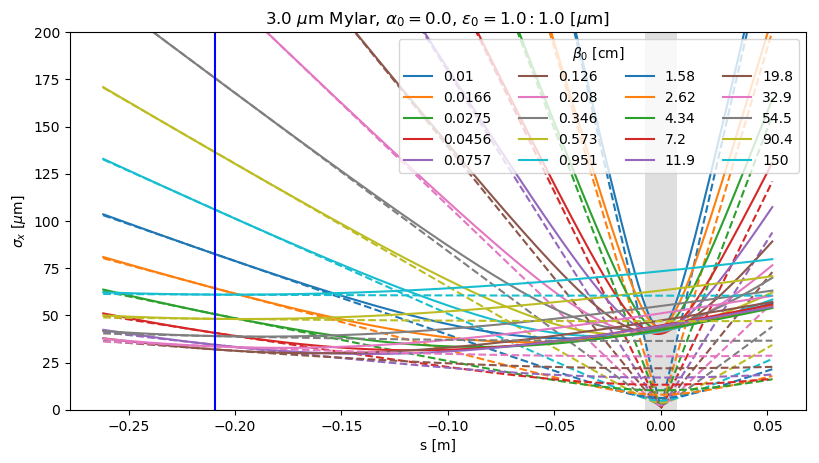

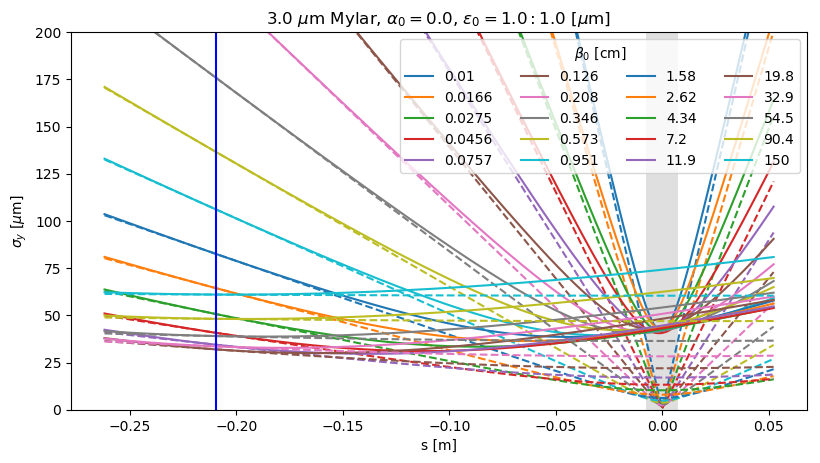

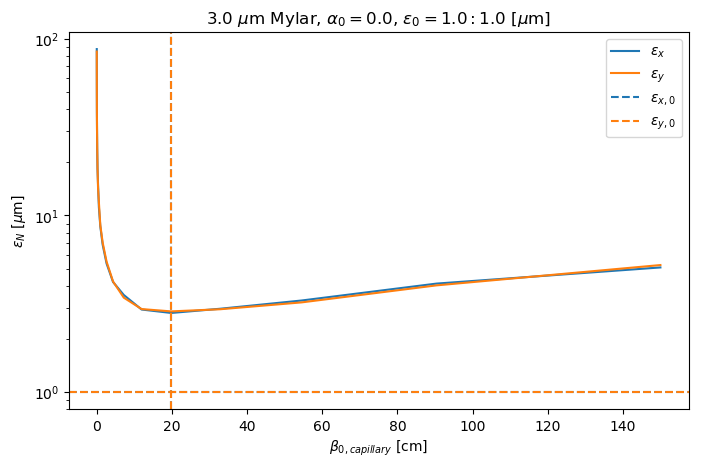

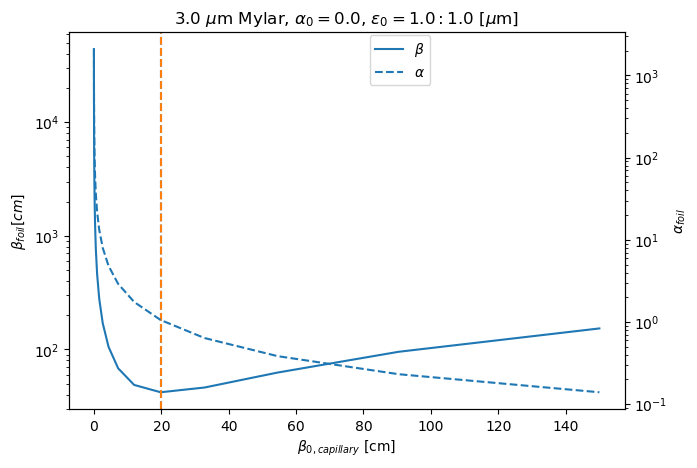

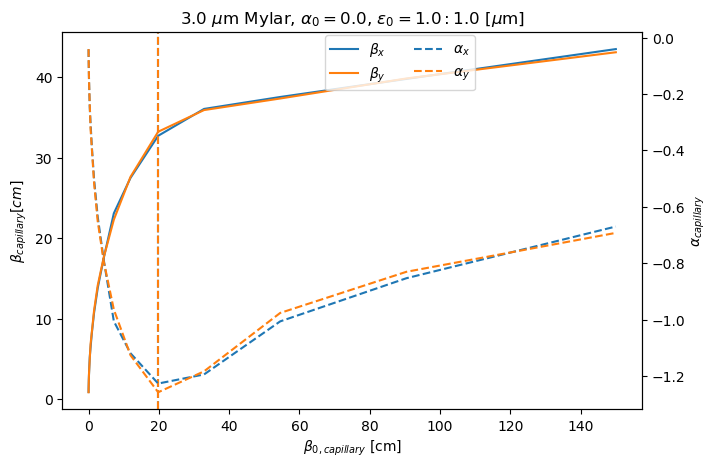

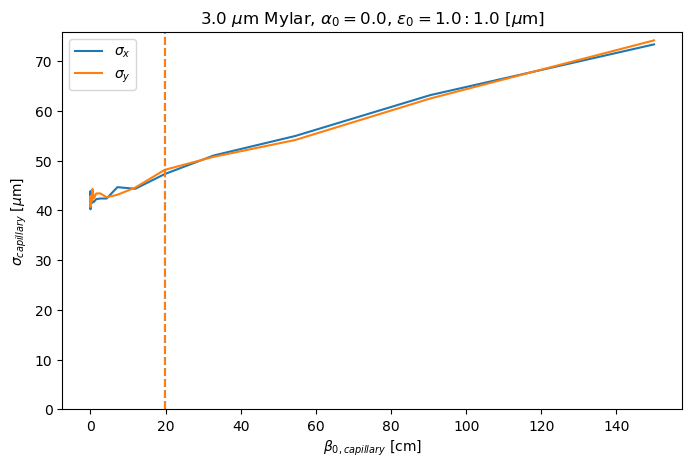

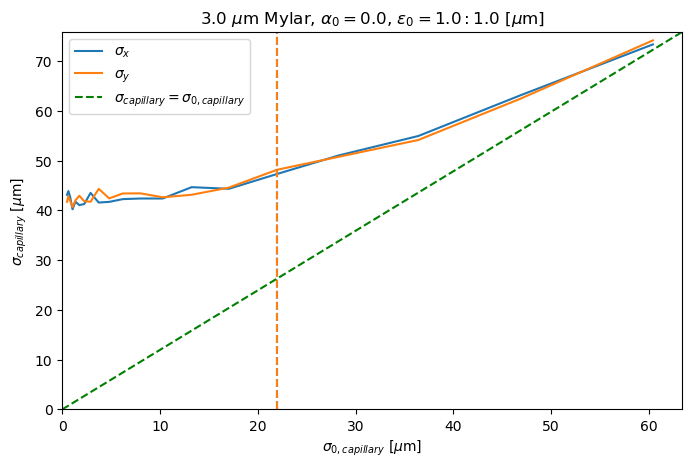

In [7]:
runSimulations(alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

This shows what happens if we try to foxus ON the lens, and then inserting the foil.
Smallest sigma is about 30 um.

Let's try to focus before the lens, i.e. alpha_0 < 1:

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=-1.0$, $\varepsilon_0 = 1.0:1.0$ [$\mu$m]'
gamma_rel = 410.958904109589
beta_rel  = 0.9999970394400621

Making folder 'plots/beamParamScan_alpha0=-1.0_eps0=1.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=20'

Simulation 1 of 20
Simulating for beta_0 = 0.0001 [m]
Sigma_0               = 0.49328901643801515 and 0.49328901643801515 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 1.0:877.3861:4189.0::1.0:877.3861:4189.0 -s 1 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 121.74443702023761 0.0060950598037530414 -0.03720109940305488
Twiss (Y): 121.16863446970486 0.006060740095675557 -0.03707798979896359
Sigma (X): 42.49276524807779 [um]
Sigma (Y): 42.27264111539336 [um]

Simulation 2 of 20
Simulating for beta_0 = 0.00016588009552658857 [m]
Sigma_0               = 0

Done!
Twiss (X): 7.022462040363684 0.10576677502635692 -0.6299484016559791
Twiss (Y): 7.158440476073511 0.10763638596816442 -0.6357901049132583
Sigma (X): 42.5129044737556 [um]
Sigma (Y): 43.300230503786956 [um]

Simulation 13 of 20
Simulating for beta_0 = 0.04340415657843982 [m]
Sigma_0               = 10.277017743162325 and 10.277017743162325 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 1.0:1.6468026298989256:8.653453333272008::1.0:1.6468026298989256:8.653453333272008 -s 13 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 5.136417234588743 0.14024583620965517 -0.8234384854018244
Twiss (Y): 5.298904829276138 0.14435730318554862 -0.8385335008196695
Sigma (X): 41.867456808822915 [um]
Sigma (Y): 43.1433521033464 [um]

Simulation 14 of 20
Simulating for beta_0 = 0.07199885639482606 [m]
Sigma_0  

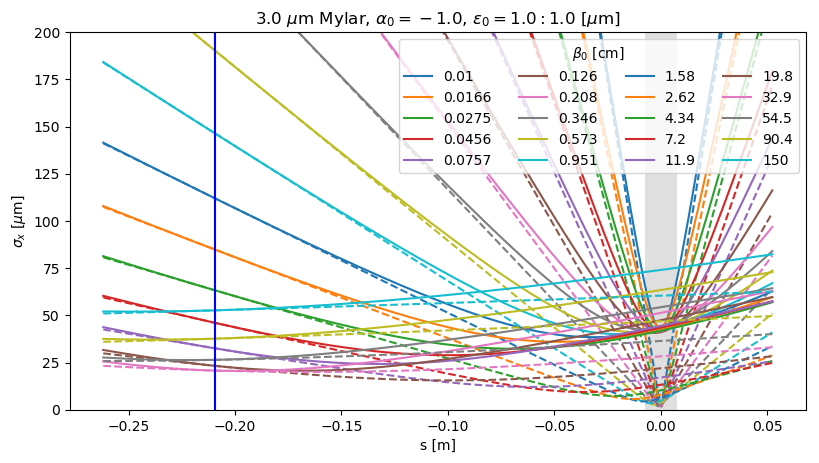

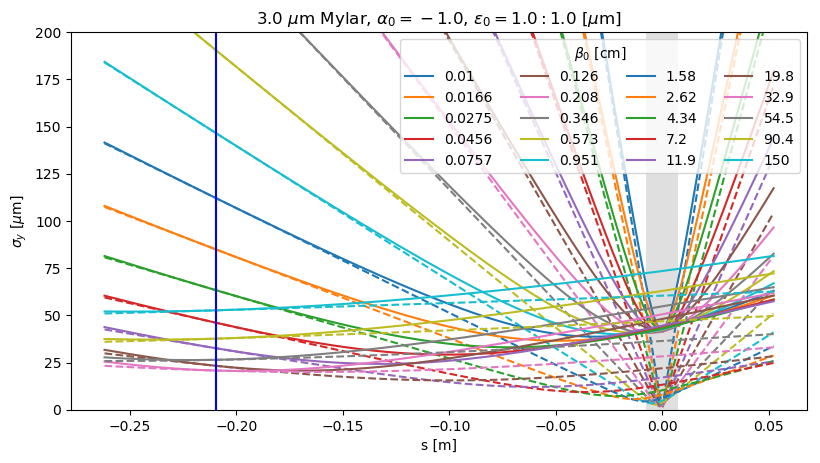

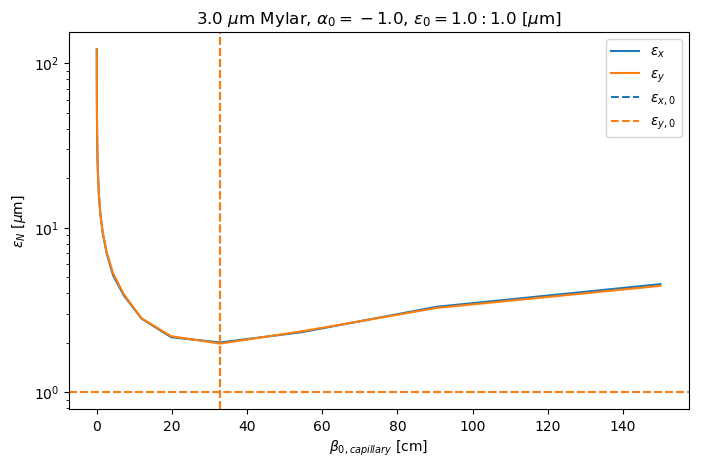

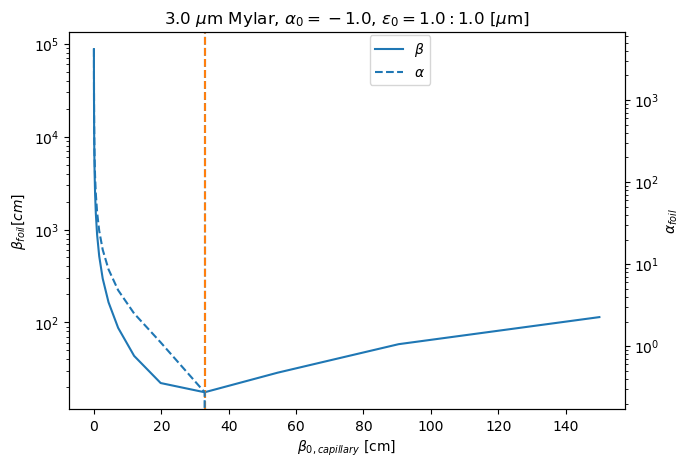

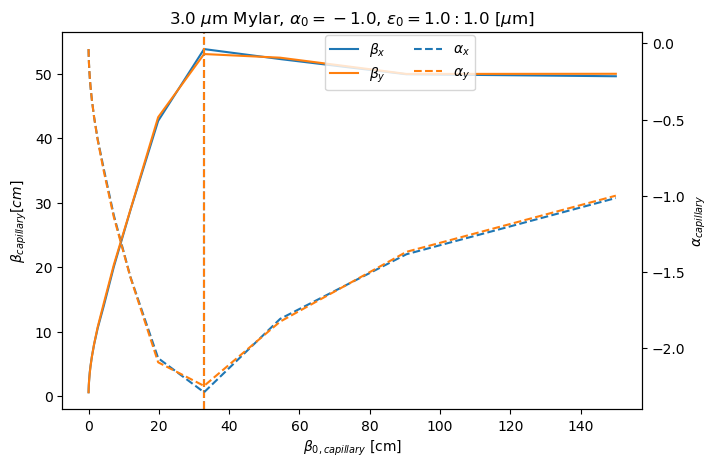

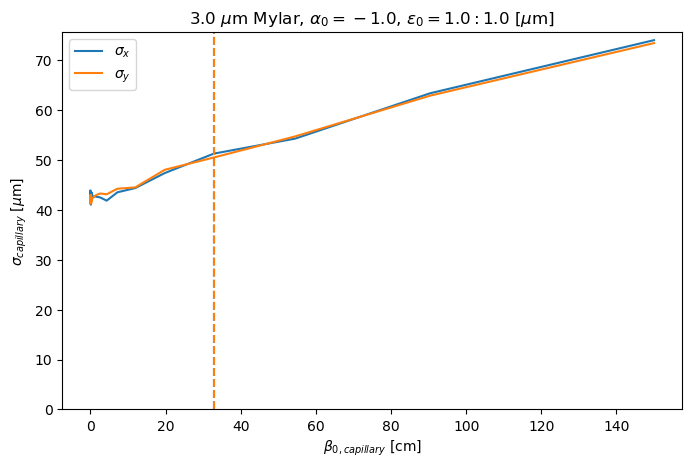

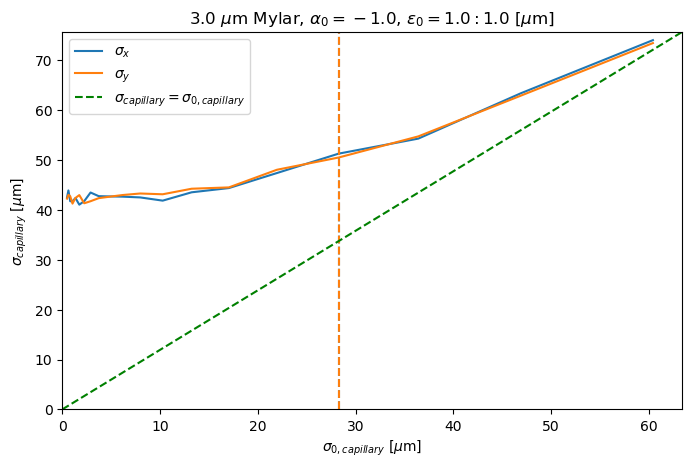

In [8]:
runSimulations(alpha_0=-1.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 3.0:3.0$ [$\mu$m]'
gamma_rel = 410.958904109589
beta_rel  = 0.9999970394400621

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=3.0:3.0_THICK=0.003_MAT=G4_MYLAR_Npoints=20'

Simulation 1 of 20
Simulating for beta_0 = 0.0001 [m]
Sigma_0               = 0.8544016392863213 and 0.8544016392863213 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 3.0:438.9026:2095.0::3.0:438.9026:2095.0 -s 1 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 142.28636289856655 0.004746405681306848 -0.02260123220537643
Twiss (Y): 155.478373711345 0.005181758351103814 -0.0245465909159205
Sigma (X): 40.5382981255611 [um]
Sigma (Y): 44.2766768929247 [um]

Simulation 2 of 20
Simulating for beta_0 = 0.00016588009552658857 [m]
Sigma_0               = 1.100421865

Done!
Twiss (X): 9.793545319501671 0.08429151927361427 -0.36431093586318686
Twiss (Y): 9.595755816283502 0.08251777439721511 -0.35528668347422154
Sigma (X): 44.8191230901695 [um]
Sigma (Y): 43.89497363920819 [um]

Simulation 13 of 20
Simulating for beta_0 = 0.04340415657843982 [m]
Sigma_0               = 17.800316881443987 and 17.800316881443987 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 3.0:1.0546033932386827:4.826726666636004::3.0:1.0546033932386827:4.826726666636004 -s 13 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 7.716280178502658 0.10782048909942923 -0.434033915880752
Twiss (Y): 7.6958954318178625 0.10743854684566086 -0.43217686017459955
Sigma (X): 44.99415381177055 [um]
Sigma (Y): 44.855023387787796 [um]

Simulation 14 of 20
Simulating for beta_0 = 0.07199885639482606 [m]
Sigma_

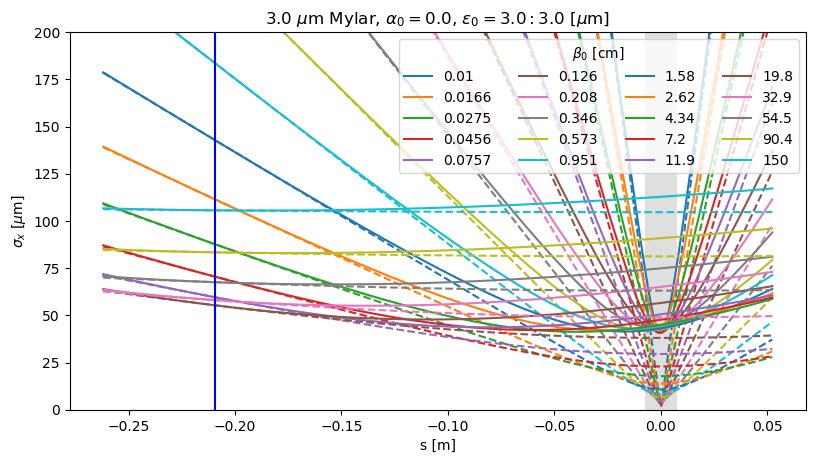

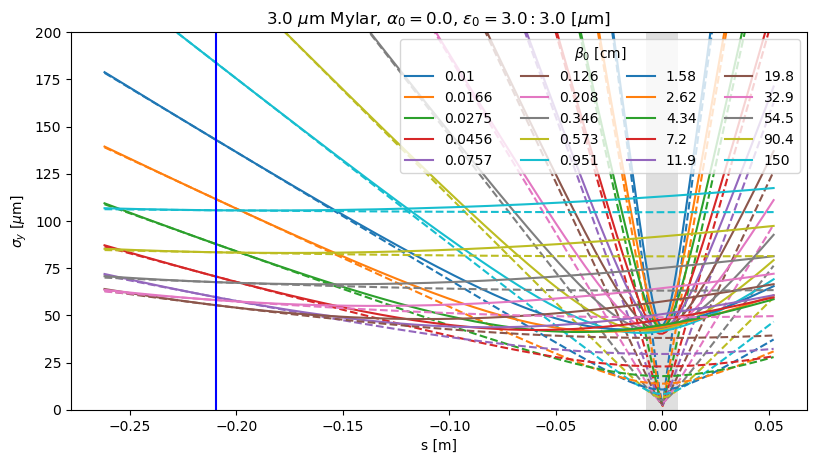

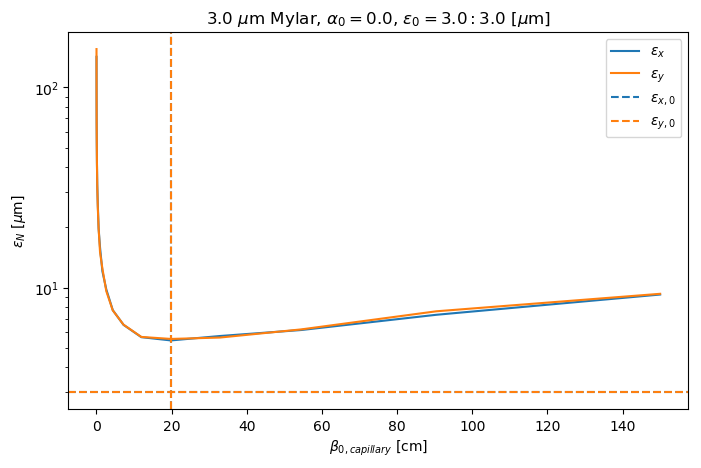

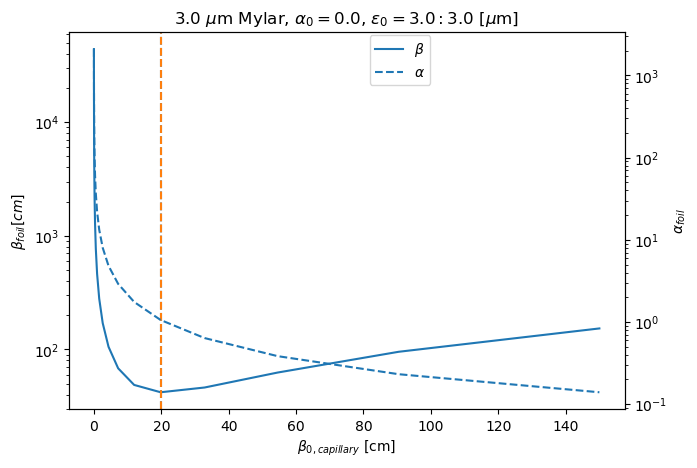

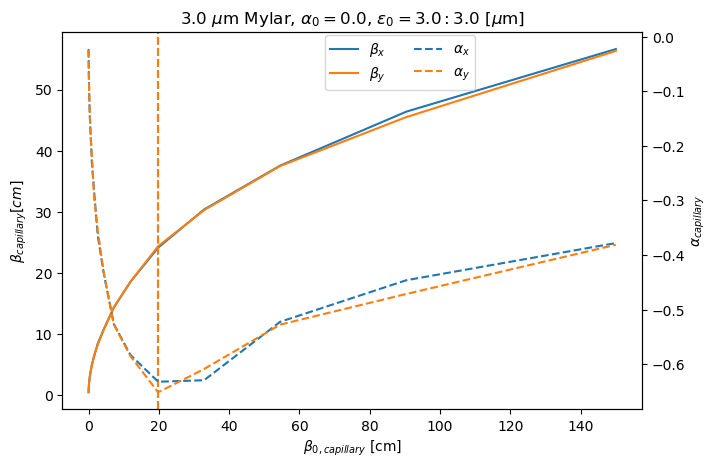

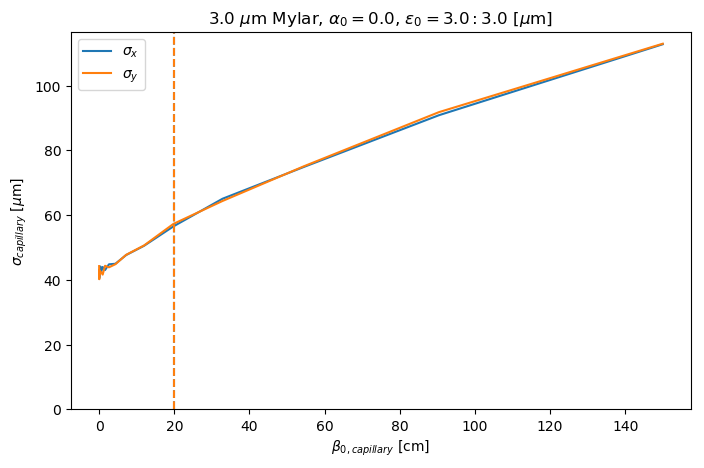

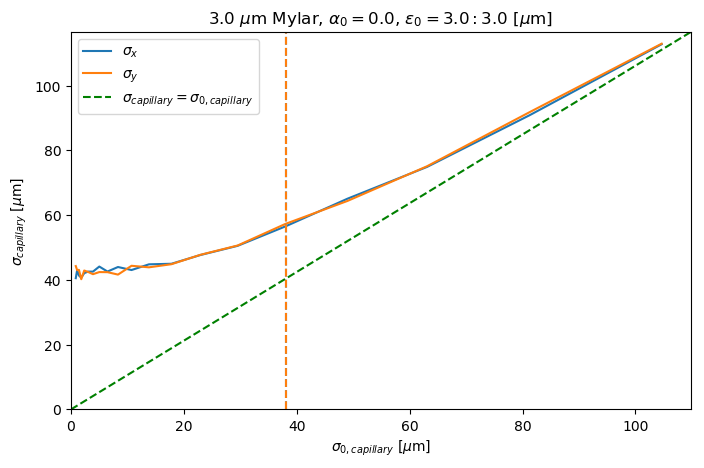

In [9]:
runSimulations(eps_0x=3.0, eps_0y=3.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 5.0:5.0$ [$\mu$m]'
gamma_rel = 410.958904109589
beta_rel  = 0.9999970394400621

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=5.0:5.0_THICK=0.003_MAT=G4_MYLAR_Npoints=20'

Simulation 1 of 20
Simulating for beta_0 = 0.0001 [m]
Sigma_0               = 1.1030277733094132 and 1.1030277733094132 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 5.0:438.9026:2095.0::5.0:438.9026:2095.0 -s 1 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 188.0129190965885 0.0037630398630806943 -0.018246153581851512
Twiss (Y): 196.44815144043758 0.003928314945856743 -0.01821095575875401
Sigma (X): 41.49203171992728 [um]
Sigma (Y): 43.33397899593575 [um]

Simulation 2 of 20
Simulating for beta_0 = 0.00016588009552658857 [m]
Sigma_0               = 1.420

Done!
Twiss (X): 13.048231153603348 0.06743968673718279 -0.2740187130147241
Twiss (Y): 12.773910256239944 0.06596692869999872 -0.2661559465844638
Sigma (X): 46.27378651306702 [um]
Sigma (Y): 45.2820946562918 [um]

Simulation 13 of 20
Simulating for beta_0 = 0.04340415657843982 [m]
Sigma_0               = 22.980110279682435 and 22.980110279682435 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 5.0:1.0546033932386827:4.826726666636004::5.0:1.0546033932386827:4.826726666636004 -s 13 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 10.473147524703533 0.08808787397524138 -0.3218179315437775
Twiss (Y): 10.407116607799384 0.08746642752408765 -0.3180790197316407
Sigma (X): 47.38033425797944 [um]
Sigma (Y): 47.063839054677146 [um]

Simulation 14 of 20
Simulating for beta_0 = 0.07199885639482606 [m]
Sigma

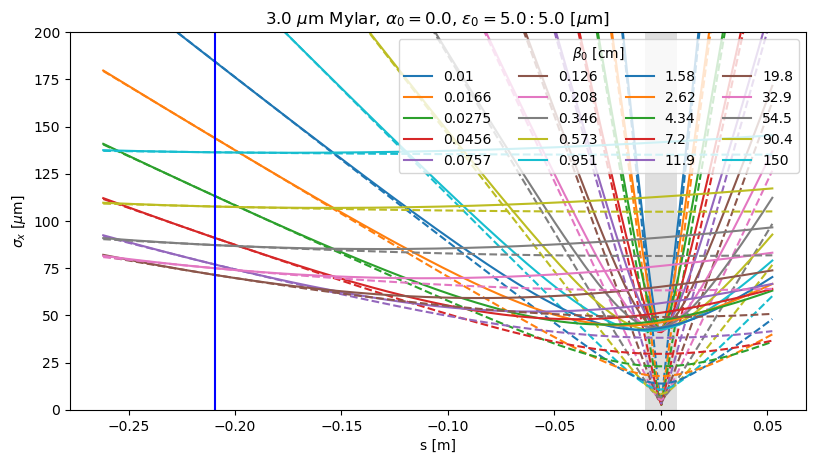

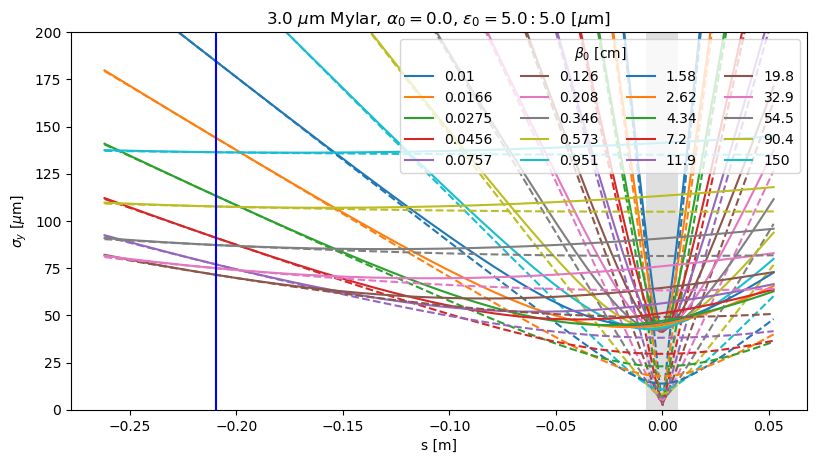

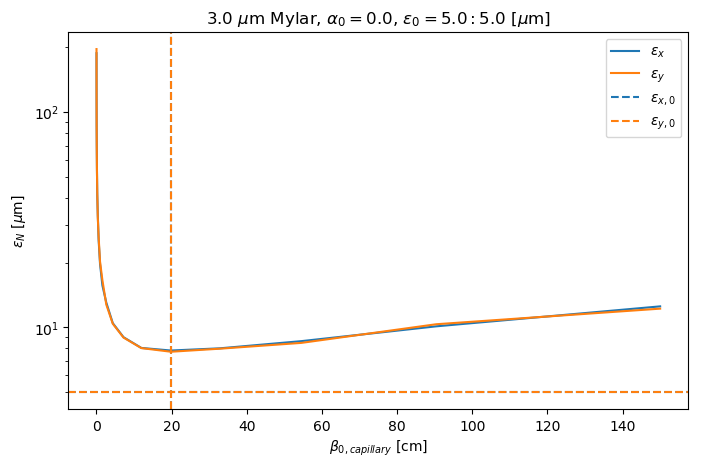

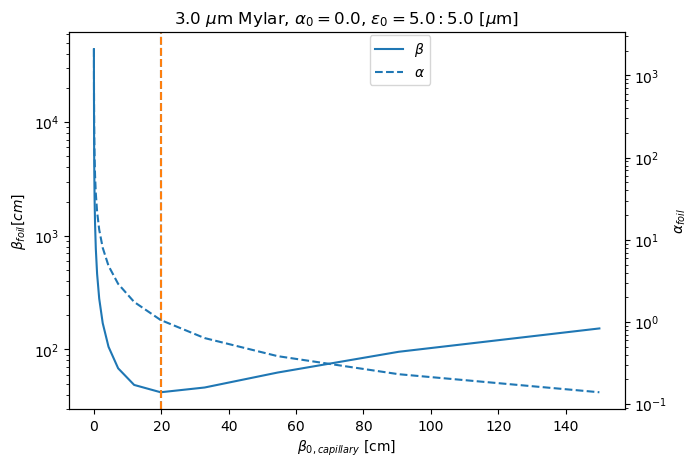

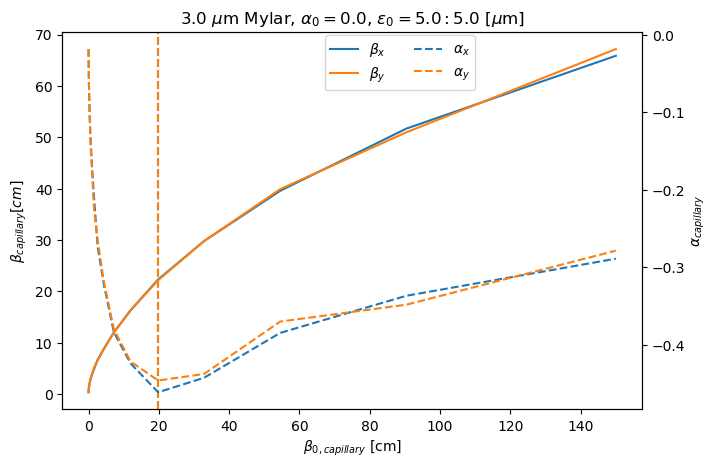

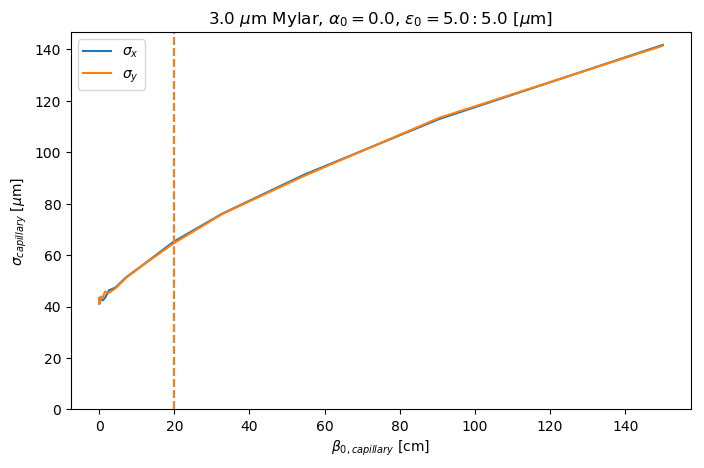

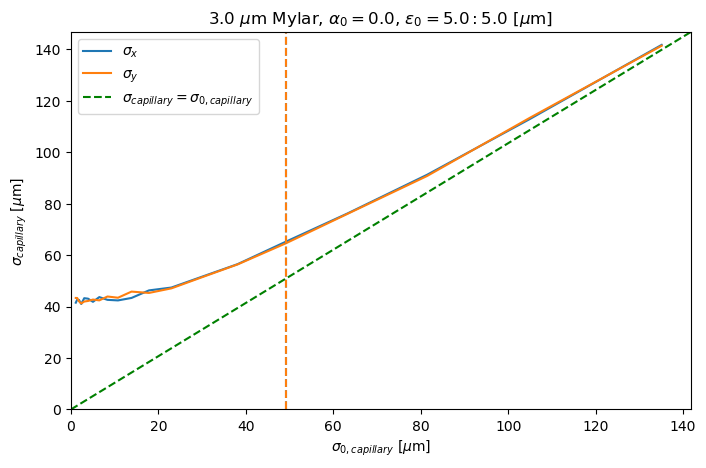

In [10]:
runSimulations(eps_0x=5.0, eps_0y=5.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)

plottile  = '3.0 $\mu$m Mylar, $\alpha_0=0.0$, $\varepsilon_0 = 10.0:1.0$ [$\mu$m]'
gamma_rel = 410.958904109589
beta_rel  = 0.9999970394400621

Making folder 'plots/beamParamScan_alpha0=0.0_eps0=10.0:1.0_THICK=0.003_MAT=G4_MYLAR_Npoints=20'

Simulation 1 of 20
Simulating for beta_0 = 0.0001 [m]
Sigma_0               = 1.5599168366883678 and 0.49328901643801515 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 10.0:438.9026:2095.0::1.0:438.9026:2095.0 -s 1 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 269.64587508996294 0.00269847185138768 -0.012570566868544616
Twiss (Y): 88.87992291718565 0.008886512812165756 -0.04258800928798284
Sigma (X): 42.078212466913584 [um]
Sigma (Y): 43.83984054997142 [um]

Simulation 2 of 20
Simulating for beta_0 = 0.00016588009552658857 [m]
Sigma_0               = 2.

Done!
Twiss (X): 19.59167437476596 0.050716762612587986 -0.178669010562386
Twiss (Y): 5.410140718602249 0.13943875040161074 -0.6423807300852912
Sigma (X): 49.17144650124184 [um]
Sigma (Y): 42.84473562110199 [um]

Simulation 13 of 20
Simulating for beta_0 = 0.04340415657843982 [m]
Sigma_0               = 32.49878362235628 and 10.277017743162325 [um]
Running command line: './MiniScatter -t 0.003 -m G4_MYLAR -d 209.50000000000003 -p QGSP_BERT__SS -n 10000000 -e 210.0 -z *-0.003 -c 10.0:1.0546033932386827:4.826726666636004::1.0:1.0546033932386827:4.826726666636004 -s 13 -f output -o /home/kyrsjo/cernbox/MiniScatter/examples/tmp -q --cutoffRadius 200.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
Twiss (X): 16.392125721278052 0.0693548412458338 -0.20507389798136474
Twiss (Y): 4.209624104513311 0.17559603353754186 -0.788665721637161
Sigma (X): 52.59657622877732 [um]
Sigma (Y): 42.41118968796022 [um]

Simulation 14 of 20
Simulating for beta_0 = 0.07199885639482606 [m]
Sigma_0  

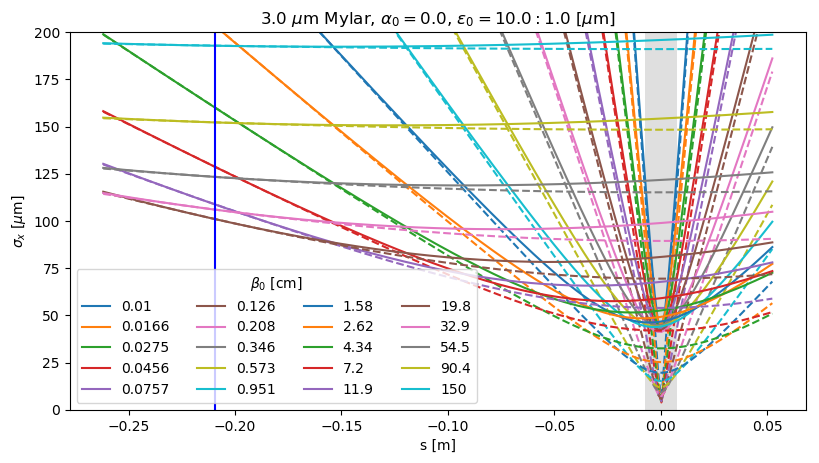

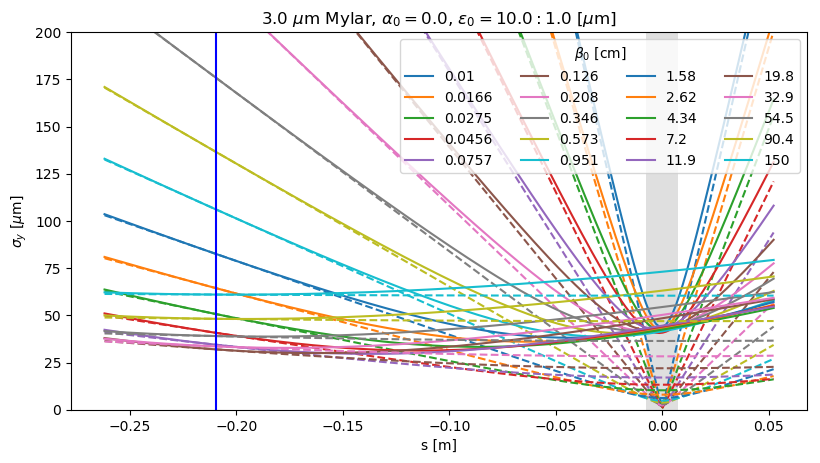

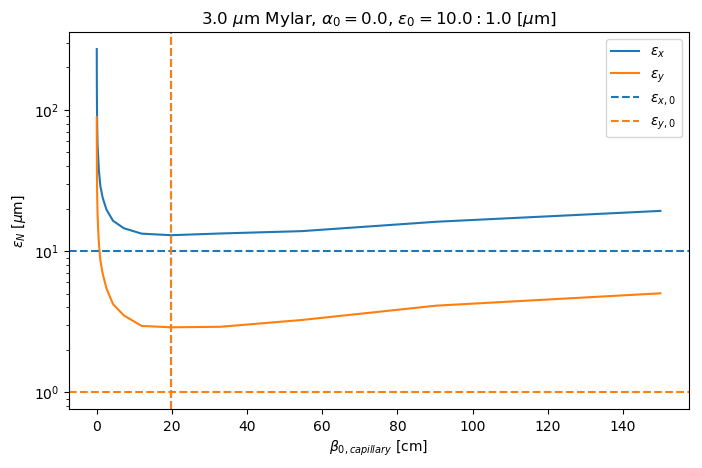

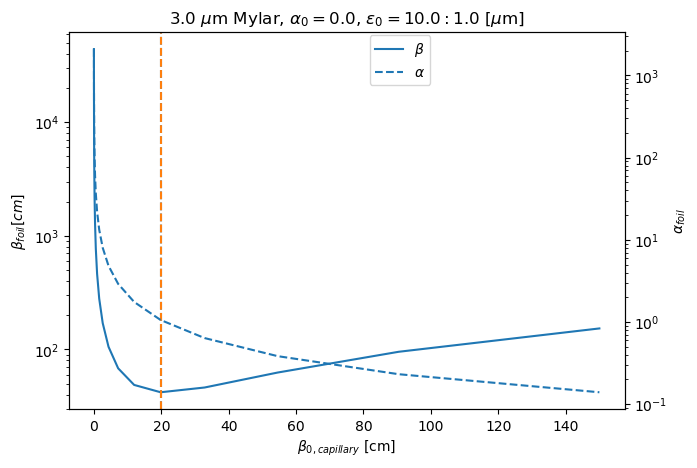

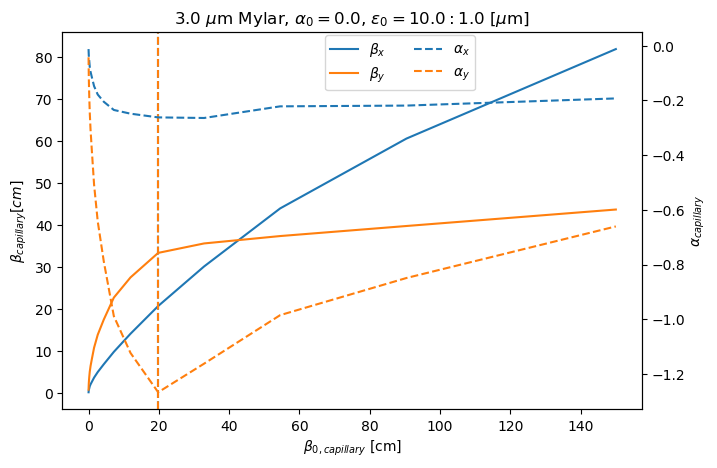

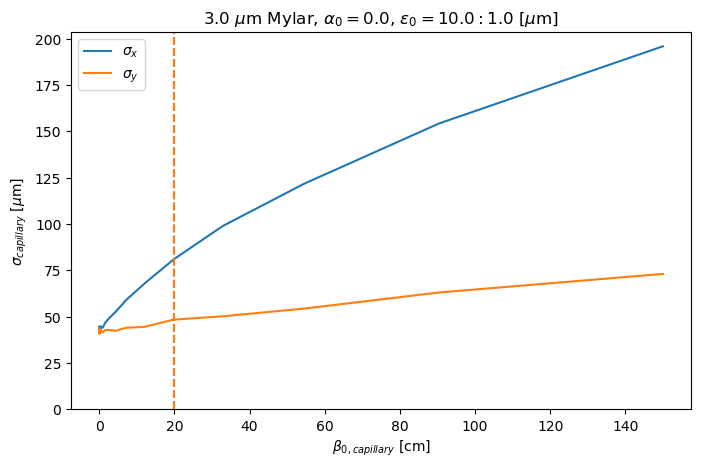

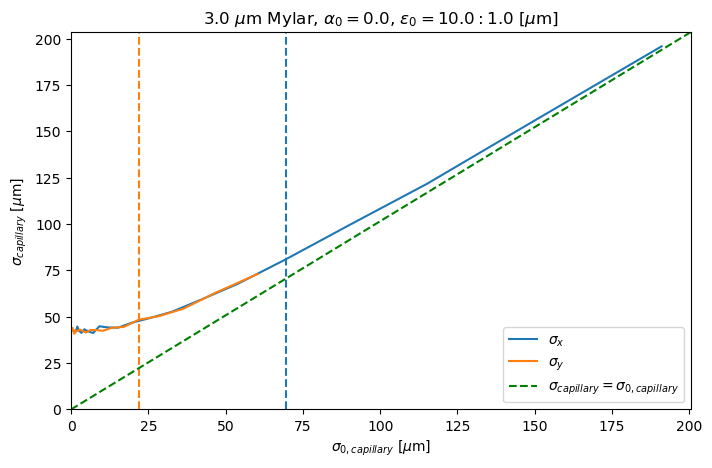

In [11]:
runSimulations(eps_0x=10.0, eps_0y=1.0, alpha_0=0.0,N=NUMEVENTS,N_beta=NUMBETA)